## Value function approximation with pytorch

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import scipy
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
def create_weighted_directed_graph_from_adj_matrix(adjacency_matrix):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    num_nodes = adjacency_matrix.shape[0]
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges from adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = adjacency_matrix[i, j]
            if weight > 0:  # Add an edge only if weight is greater than 0
                G.add_edge(i, j, weight=weight)

    return G

# Test the function
num_nodes = 10

# Create a num_nodes by num_nodes matrix filled with zeros
adjacency_matrix = np.zeros((num_nodes, num_nodes))

# Fill in the adjacency matrix with random edge weights
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:  # No self-connections
            weight = random.randint(1, 10)
            adjacency_matrix[i, j] = weight

# add some random zeros to the adjacency matrix
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:  # No self-connections
            if random.randint(1, 2) == 1:
                adjacency_matrix[i, j] = 0

# triangular matrix
# adjacency_matrix = np.triu(adjacency_matrix)

print("Adjacency Matrix:")
print(adjacency_matrix)

# Print the edges of the graph
# print("Edges of the Graph:")
# for edge in G.edges(data=True):
#     print(edge)


Adjacency Matrix:
[[ 0.  0.  0.  0.  4.  3.  0.  0.  5.  4.]
 [ 9.  0.  0.  0.  0.  0.  0.  7.  8.  0.]
 [ 0.  5.  0.  0.  8. 10.  6.  6.  7.  0.]
 [ 5.  7.  3.  0.  4.  4.  8.  5.  2.  0.]
 [ 0.  0. 10.  0.  0.  5.  9.  1.  6.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  6.  0.  0.  0. 10.  1.  4.]
 [ 0.  6.  0.  4.  9. 10.  0.  0. 10.  9.]
 [10. 10.  0.  0. 10.  4. 10.  7.  0.  4.]
 [ 0.  4.  7.  0.  9.  6.  0.  0.  4.  0.]]


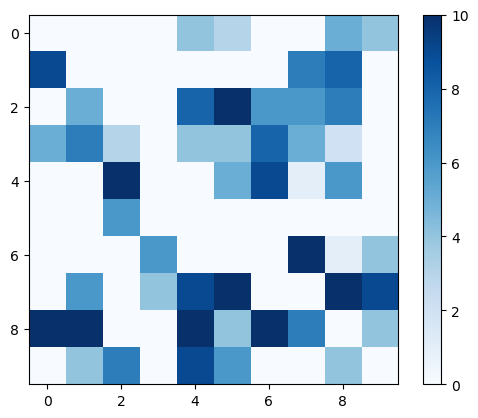

In [4]:
G = create_weighted_directed_graph_from_adj_matrix(adjacency_matrix)
plt.imshow(adjacency_matrix,cmap='Blues')
plt.colorbar()

{(0, 4): Text(-0.7598378691496642, 0.10420492454461022, '4.0'),
 (0, 5): Text(-0.6617020441604398, -0.5631781094717068, '3.0'),
 (0, 8): Text(-0.2575357844006907, -0.4369591966543676, '5.0'),
 (0, 9): Text(0.04890882712651112, -0.2787249382329819, '4.0'),
 (1, 0): Text(0.12723001276790186, 0.21836471072887764, '9.0'),
 (1, 7): Text(0.1953816037697526, 0.7160519356599355, '7.0'),
 (1, 8): Text(0.6152342028314074, 0.0982031760273398, '8.0'),
 (2, 1): Text(0.6439508930528444, 0.7453565802383266, '5.0'),
 (2, 4): Text(-0.24311698886472166, 0.6311967940540593, '8.0'),
 (2, 5): Text(-0.1449811638754972, -0.03618623996225784, '10.0'),
 (2, 6): Text(0.331455333472447, -0.015636431654951932, '6.0'),
 (2, 7): Text(-0.16066750317740297, 0.7078814324876772, '6.0'),
 (2, 8): Text(0.25918509588425187, 0.09003267285508137, '7.0'),
 (3, 0): Text(-0.38775001558630856, -0.1593535080961971, '5.0'),
 (3, 1): Text(0.4850199716457896, 0.37580886458551027, '7.0'),
 (3, 2): Text(0.12897086469863397, 0.3676383

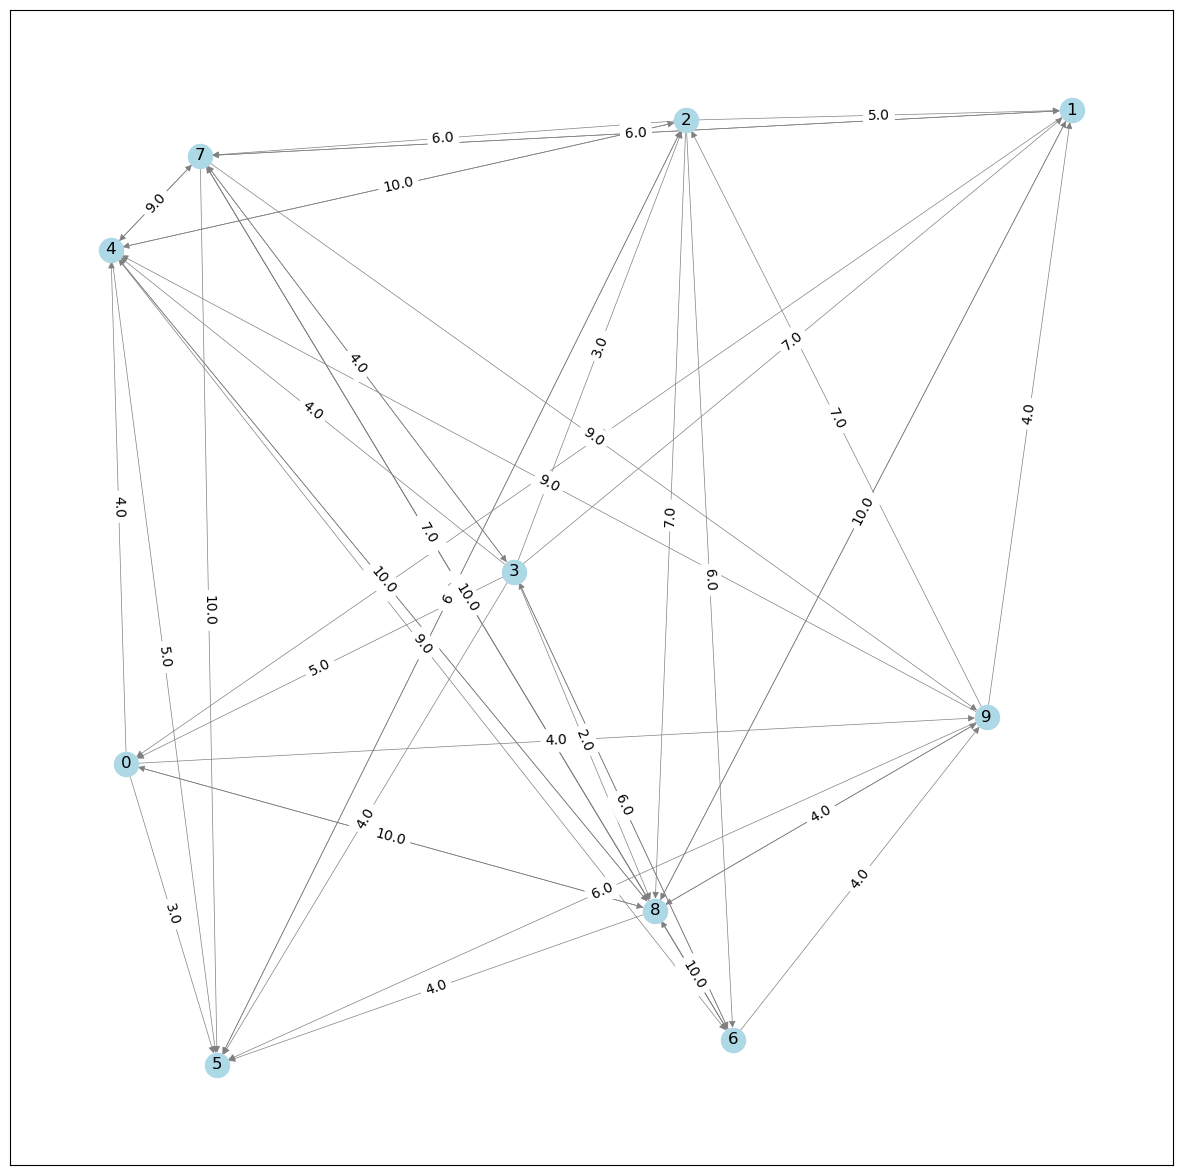

In [5]:
pos = nx.kamada_kawai_layout(G)
# set figure size
plt.figure(figsize=(15,15))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width=0.5, alpha=1)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, num_nodes):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(num_nodes*2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class RLAgent_vfa_torch:
    def __init__(self, graph, num_nodes, alpha=0.01, gamma=0.95, epsilon=0.1, lambda_=0.9, net=QNet(num_nodes).to(device)):
        self.graph = graph
        self.num_nodes = num_nodes
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.net = net
        self.optimizer = optim.Adam(self.net.parameters(), lr=alpha)

    def get_features(self, state, action):
        features = np.zeros(self.num_nodes * 2)
        features[state] = 1
        features[self.num_nodes + action] = 1
        return torch.FloatTensor(features).to(device)

    def get_q_value(self, state, action):
        features = self.get_features(state, action)
        return self.net(features)

    def choose_action(self, state):
        neighbors = list(self.graph.neighbors(state))
        q_values = [self.get_q_value(state, action).item() for action in neighbors]
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(neighbors)
        else:
            action = neighbors[np.argmax(q_values)]
        return action

    def update(self, state, action, reward, next_state, next_action):
        q_value = self.get_q_value(state, action)
        next_q_value = self.get_q_value(next_state, next_action)
        target = reward + self.gamma * next_q_value

        self.optimizer.zero_grad()
        loss = nn.MSELoss()(q_value, target.detach())
        loss.backward()
        self.optimizer.step()

    def learn(self, start_node, end_node, num_episodes):
        for _ in range(num_episodes):
            state = start_node
            action = self.choose_action(state)
            while state != end_node:
                reward = -self.graph.edges[state, action]['weight']
                next_state = action
                next_action = self.choose_action(next_state)
                self.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action

    def get_optimal_path(self, start_node, end_node):
        path = [start_node]
        state = start_node
        while state != end_node:
            neighbors = list(self.graph.neighbors(state))
            q_values = [self.get_q_value(state, action).item() for action in neighbors]
            action = neighbors[np.argmax(q_values)]
            state = action
            path.append(state)
        return path

num_nodes = 20
num_episodes = 1000

agent = RLAgent_vfa_torch(G, num_nodes)

agent.learn(start_node=6, end_node=4, num_episodes=num_episodes)

path = agent.get_optimal_path(start_node=6, end_node=4)
print(path)


[6, 3, 4]


In [8]:
RLA2 = RLAgent_vfa_torch(graph=G, num_nodes=20,net=agent.net)

In [9]:
path = RLA2.get_optimal_path(start_node=6, end_node=4)